In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef

import fragility_index as fi

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [2]:
N_seeds=20      # number of seeds
data_name = 'LiverDisorders'


lr = LogisticRegression()
svc = LinearSVC(C=1.0,max_iter=5000)

model_name_list = np.array(
    [[lr, 'lr'],
    [svc, 'sv']])


x,y = fi.Data_load(data_name)      # import data

perf = pd.DataFrame(columns = ['name','AUC','bAUC','FI','Accuracy', 'Precision', 'Recall', 'Conf_matrix' 'error'])       # record results

for clf, name in model_name_list:
    AUC_mean = 0
    FI_mean = 0
    bAUC_mean = 0
    accuracy_mean = 0
    top_k_accuracy_mean = 0
    precision_mean = 0
    recall_mean = 0
    f1_mean = 0
    mcc_mean = 0
    conf_matrix_mean = np.zeros((2,2))
    error_total = np.array([])
    for _seed in range(N_seeds):
    
        np.random.seed(_seed) 
        X_sample, X_test, y_sample, y_test = train_test_split(x, y, test_size=0.2)
        
        scaler = StandardScaler()
        X_sample = scaler.fit_transform(X_sample)
        X_test = scaler.transform(X_test)
        X = scaler.transform(x)
        
        
        clf.fit(X_sample, y_sample)
        func = clf.decision_function(X_test)
        prob_pos = 1/(1 + np.exp(-func))        # get probability by sigmoid function
        y_predict = clf.predict(X_test)
                
        AUC = roc_auc_score(y_test, prob_pos)
        FI, error = fi.FI_calculation(prob_pos,y_test)
        bAUC = fi.bAUC_calculation(error)

        accuracy = accuracy_score(y_test, y_predict)
        accuracy_mean += accuracy / N_seeds

        f1 = f1_score(y_test, y_predict)
        f1_mean += f1 / N_seeds
        
        mcc = matthews_corrcoef(y_test, y_predict)
        mcc_mean += mcc / N_seeds

        precision = precision_score(y_test, y_predict)
        precision_mean += precision / N_seeds

        recall = recall_score(y_test, y_predict)
        recall_mean += recall / N_seeds

        conf_matrix = confusion_matrix(y_test, y_predict, normalize='all')
        # print(conf_matrix)
        conf_matrix_mean += conf_matrix / N_seeds

        AUC_mean += AUC/N_seeds
        FI_mean += FI/N_seeds
        bAUC_mean += bAUC/N_seeds
        error_total = np.concatenate((error_total,error))


    perf_clf = pd.DataFrame({'name':[name],
                             'AUC':[AUC_mean],
                             'bAUC':[bAUC_mean],
                             'FI':[FI_mean],
                             'Accuracy':[accuracy_mean],
                             'TN_and_FP':[conf_matrix_mean[0]],
                             'FN_and_TP':[conf_matrix_mean[1]],
                             'Precision':[precision_mean],
                             'Recall':[recall_mean],
                             'F1': [f1_mean],
                             'MCC':[mcc_mean],
                             'error':[error_total]})
    
    perf = pd.concat([perf,perf_clf])
    

print(perf[['name','AUC','bAUC','FI','Accuracy', 'Precision', 'Recall', 'TN_and_FP','FN_and_TP', 'F1', 'MCC']])    


/tmp/ipykernel_7528/1192827561.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf = pd.concat([perf,perf_clf])
/home/zagreus/Documents/UIU - Study Documents/9th Trimester/CSE 4891 Data Mining/Fragility-index_DataMining/venv/lib64/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/zagreus/Documents/UIU - Study Documents/9th Trimester/CSE 4891 Data Mining/Fragility-index_DataMining/venv/lib64/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to

  name       AUC      bAUC        FI  Accuracy  Precision    Recall  \
0   lr  0.720699  0.362728  0.214569  0.686232   0.717344  0.513842   
0   sv  0.721722  0.356374  0.113251  0.689130   0.714857  0.526150   

                                   TN_and_FP  \
0  [0.4557971014492753, 0.09420289855072465]   
0  [0.4528985507246377, 0.09710144927536234]   

                                    FN_and_TP        F1       MCC  
0   [0.2195652173913043, 0.23043478260869565]  0.592769  0.367711  
0  [0.21376811594202894, 0.23623188405797105]  0.600505  0.372608  


/home/zagreus/Documents/UIU - Study Documents/9th Trimester/CSE 4891 Data Mining/Fragility-index_DataMining/venv/lib64/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/zagreus/Documents/UIU - Study Documents/9th Trimester/CSE 4891 Data Mining/Fragility-index_DataMining/venv/lib64/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


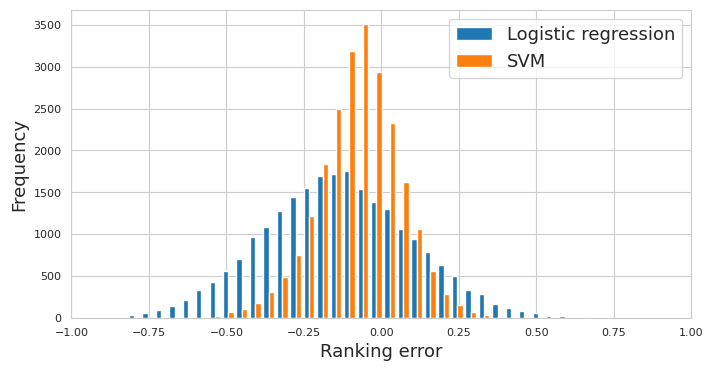

In [3]:
plt.figure(figsize=(8, 4))
plt.hist(perf['error'].values,bins=40)
plt.legend(['Logistic regression','SVM'],fontsize=13)
ax = plt.gca()
ax.set_xlim(-1,1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Ranking error', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.savefig('rank_error_LD.pdf', dpi=300)
plt.show()    

# Data Australia

/tmp/ipykernel_7528/2769065274.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perf = pd.concat([perf,perf_clf])
/home/zagreus/Documents/UIU - Study Documents/9th Trimester/CSE 4891 Data Mining/Fragility-index_DataMining/venv/lib64/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/zagreus/Documents/UIU - Study Documents/9th Trimester/CSE 4891 Data Mining/Fragility-index_DataMining/venv/lib64/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to

  name       AUC      bAUC        FI  Accuracy  Precision    Recall  \
0   lr  0.929181  0.811059  0.160828  0.865580   0.829041  0.884559   
0   sv  0.927924  0.816726  0.082031  0.859058   0.804857  0.907739   

                                   TN_and_FP  \
0  [0.46920289855072456, 0.0822463768115942]   
0  [0.4521739130434782, 0.09927536231884056]   

                                    FN_and_TP        F1       MCC  
0  [0.05217391304347827, 0.39637681159420285]  0.854878  0.732556  
0  [0.04166666666666668, 0.40688405797101446]  0.852184  0.724535  


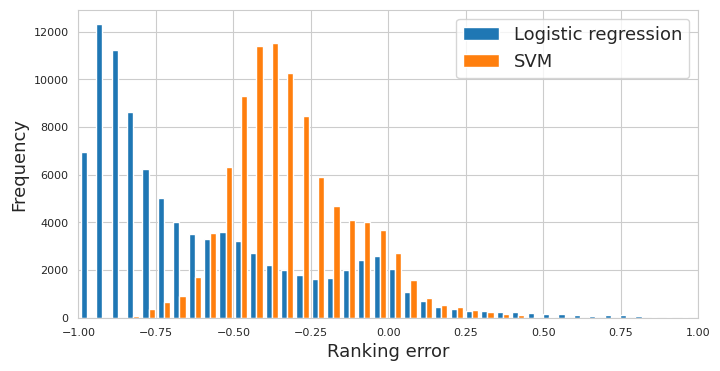

In [4]:
N_seeds=20      # number of seeds
data_name = 'Australian'


lr = LogisticRegression()
svc = LinearSVC(C=1.0,max_iter=5000)

model_name_list = np.array(
    [[lr, 'lr'],
    [svc, 'sv']])


x,y = fi.Data_load(data_name)      # import data

perf = pd.DataFrame(columns = ['name','AUC','bAUC','FI','Accuracy', 'Precision', 'Recall', 'Conf_matrix' 'error'])       # record results

for clf, name in model_name_list:
    AUC_mean = 0
    FI_mean = 0
    bAUC_mean = 0
    accuracy_mean = 0
    top_k_accuracy_mean = 0
    precision_mean = 0
    recall_mean = 0
    f1_mean = 0
    mcc_mean = 0
    conf_matrix_mean = np.zeros((2,2))
    error_total = np.array([])
    for _seed in range(N_seeds):
    
        np.random.seed(_seed) 
        X_sample, X_test, y_sample, y_test = train_test_split(x, y, test_size=0.2)
        
        scaler = StandardScaler()
        X_sample = scaler.fit_transform(X_sample)
        X_test = scaler.transform(X_test)
        X = scaler.transform(x)
        
        
        clf.fit(X_sample, y_sample)
        func = clf.decision_function(X_test)
        prob_pos = 1/(1 + np.exp(-func))        # get probability by sigmoid function
        y_predict = clf.predict(X_test)
                
        AUC = roc_auc_score(y_test, prob_pos)
        FI, error = fi.FI_calculation(prob_pos,y_test)
        bAUC = fi.bAUC_calculation(error)

        accuracy = accuracy_score(y_test, y_predict)
        accuracy_mean += accuracy / N_seeds

        f1 = f1_score(y_test, y_predict)
        f1_mean += f1 / N_seeds
        
        mcc = matthews_corrcoef(y_test, y_predict)
        mcc_mean += mcc / N_seeds

        precision = precision_score(y_test, y_predict)
        precision_mean += precision / N_seeds

        recall = recall_score(y_test, y_predict)
        recall_mean += recall / N_seeds

        conf_matrix = confusion_matrix(y_test, y_predict, normalize='all')
        # print(conf_matrix)
        conf_matrix_mean += conf_matrix / N_seeds

        AUC_mean += AUC/N_seeds
        FI_mean += FI/N_seeds
        bAUC_mean += bAUC/N_seeds
        error_total = np.concatenate((error_total,error))


    perf_clf = pd.DataFrame({'name':[name],
                             'AUC':[AUC_mean],
                             'bAUC':[bAUC_mean],
                             'FI':[FI_mean],
                             'Accuracy':[accuracy_mean],
                             'TN_and_FP':[conf_matrix_mean[0]],
                             'FN_and_TP':[conf_matrix_mean[1]],
                             'Precision':[precision_mean],
                             'Recall':[recall_mean],
                             'F1': [f1_mean],
                             'MCC':[mcc_mean],
                             'error':[error_total]})
    
    perf = pd.concat([perf,perf_clf])
    

print(perf[['name','AUC','bAUC','FI','Accuracy', 'Precision', 'Recall', 'TN_and_FP','FN_and_TP', 'F1', 'MCC']])

plt.figure(figsize=(8, 4))
plt.hist(perf['error'].values,bins=40)
plt.legend(['Logistic regression','SVM'],fontsize=13)
ax = plt.gca()
ax.set_xlim(-1,1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('Ranking error', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.savefig('rank_error_SA.pdf', dpi=300)
plt.show()